# Alzheimer Classifier

In this notebook, We will build a classifier to predict whether a patient has Alzheimer's disease or not. I will use a dataset that contains MRI images of the brain. The implementation is based on this [paper](https://www.researchgate.net/publication/349874169_A_CNN_based_framework_for_classification_of_Alzheimer's_disease).

# Introduction

Alzheimer's disease (AD) is a neurodegenerative disorder that causes memory loss and cognitive decline. It is the most common cause of dementia, accounting for 60-70% of cases. The exact cause of AD is unknown, but it is believed to be a combination of genetic, environmental, and lifestyle factors. There is currently no cure for AD, but early detection and treatment can help slow the progression of the disease. So the need for an accurate and reliable method for diagnosing AD is crucial.

In [321]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tqdm
import os
import sys
from PIL import Image
import cv2
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import data as tfdata
from tensorflow import image as tfimage
from tensorflow import io as tfio

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical, plot_model, img_to_array, normalize

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

## Dataset

The dataset used in this notebook is the [ADNI](https://www.kaggle.com/datasets/subhranilsarkar/alzheimer-s-disease-neuroimaging-adni-dataset) dataset from Kaggle. The dataset contains MRI images of the brain from patients with Alzheimer's disease and healthy controls. The dataset is divided into two classes: Mild Cognitive Impairment (MCI), and Alzheimer's disease (AD). The dataset contains a total of 1654 images, with 965 images from AD patients and 689 images from MCIs. For pre-processing, since most of the things are already done, we just need to resize the images to a fixed size.

In [322]:
AD_PATH = "../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD"
MCI_PATH = "../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI"

In [323]:
class ImageDataset:
    def __init__(self, AD_path: str, MCI_path: str, img_size: tuple[int, int] = (256, 256), batch_size: int = 32, **kwargs):
        self.AD_path = AD_path
        self.MCI_path = MCI_path
        self.img_size = img_size
        self.batch_size = batch_size
        self._load()
        
        
    def _load_image(self, path: str) -> tf.Tensor:
        img = tfio.read_file(path)
        img = tfio.decode_jpeg(img, channels=3)
        img = tfimage.resize(img, self.img_size)
        
        # img = tf.py_function(self._apply_dynamic_thresholding, [img], Tout=tf.uint8) 
        # uncomment the above line to apply dynamic thresholding
        
        img = tf.cast(img, tf.float32) / 255.0
        return img
    
    def _apply_dynamic_thresholding(self, img: tf.Tensor) -> tf.Tensor:
        img_np = img_to_array(img)
        img_np = (img_np * 255).astype(np.uint8)
        img_np = cv2.adaptiveThreshold(img_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        return tf.convert_to_tensor(img_np)
        
    def _load(self):
        MCI_files = tfio.gfile.glob(os.path.join(self.MCI_path, "*.jpg"))
        AD_files = tfio.gfile.glob(os.path.join(self.AD_path, "*.jpg"))
        
        MCI_data = tfdata.Dataset.from_tensor_slices(MCI_files)
        AD_data = tfdata.Dataset.from_tensor_slices(AD_files)
        
        MCI_data = MCI_data.map(self._load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        AD_data = AD_data.map(self._load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        MCI_label = tf.data.Dataset.from_tensor_slices([0] * len(MCI_files))
        AD_label = tf.data.Dataset.from_tensor_slices([1] * len(AD_files))
        
        MCI_data = tf.data.Dataset.zip((MCI_data, MCI_label))
        AD_data = tf.data.Dataset.zip((AD_data, AD_label))
        
        self.MCI_data = MCI_data
        self.AD_data = AD_data
        
        self.concat_data = tf.data.Dataset.concatenate(MCI_data, AD_data)
    
    
    
    def augment_image(self, img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.1, 0.2)
        img = tf.image.random_hue(img, 0.1)
        img = tf.image.random_saturation(img, 0.1, 0.2)
        img = tf.image.random_crop(img, size=[*self.img_size, 1])
        return img, label
    
    def augment_dataset(self, num_samples: int = 4):
        MCI_data = self.MCI_data
        AD_data = self.AD_data
        
        for _ in range(num_samples):
            MCI_data = MCI_data.concatenate(self.MCI_data.map(self.augment_image))
            AD_data = AD_data.concatenate(self.AD_data.map(self.augment_image))
        
        self.MCI_data = MCI_data
        self.AD_data = AD_data
        
        self.concat_data = tf.data.Dataset.concatenate(MCI_data, AD_data)
            
            
                        
    def get_batch(self) -> tuple[tf.data.Dataset, tf.data.Dataset]:
        AD_data = self.AD_data.shuffle(1000).batch(self.batch_size)
        MCI_data = self.MCI_data.shuffle(1000).batch(self.batch_size)
        return AD_data, MCI_data
    
    def get_data(self) -> tuple[tf.data.Dataset, tf.data.Dataset]:
        return self.AD_data, self.MCI_data
    
    def get_sample_data(self, num_samples: int = 1) -> tuple[tf.Tensor, tf.Tensor]:
        AD_samples = [next(iter(self.AD_data.shuffle(buffer_size=100))) for _ in range(num_samples)]
        MCI_samples = [next(iter(self.MCI_data.shuffle(buffer_size=100))) for _ in range(num_samples)]
        return AD_samples, MCI_samples
    
    def _split_data(self, data: tf.data.Dataset, split_size: float = .05) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
        dataset_size = len(data)
        test_size = int(split_size * dataset_size)
        val_size = int((1 - split_size) * dataset_size * .1)
        train_size = dataset_size - test_size
        
        data = data.shuffle(dataset_size)
        
        test_data = data.take(test_size)
        data = data.skip(test_size)
        
        val_data = data.take(val_size)
        data = data.skip(val_size)
        
        train_data = data.take(train_size)
        data = data.skip(train_size)
        
        return train_data, val_data, test_data
    
    def split_train_test_validation(self, split_size: float = .05):
        ADI_train, ADI_val, ADI_test = self._split_data(self.AD_data, split_size)
        MCI_train, MCI_val, MCI_test = self._split_data(self.MCI_data, split_size)
        
        self.train = tf.data.Dataset.concatenate(ADI_train, MCI_train)
        self.val = tf.data.Dataset.concatenate(ADI_val, MCI_val)
        self.test = tf.data.Dataset.concatenate(ADI_test, MCI_test)
        
    
    def show_sample(self, num_samples: int = 1):
        AD_samples, MCI_samples = self.get_sample_data(num_samples)
        
        figs, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples)) 
        if num_samples == 1:
            axes = axes[np.newaxis, :]
        for i in range(num_samples):
            axes[i, 0].imshow(AD_samples[i][0])
            axes[i, 0].set_title("AD")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(MCI_samples[i][0])
            axes[i, 1].set_title("MCI")
            axes[i, 1].axis("off")
        
        plt.show()
    
    def plot_distribution(self):
        plt.figure(figsize=(10, 5))
        
        sns.countplot(x="label", data=pd.DataFrame({"label": [0] * len(self.MCI_data) + [1] * len(self.AD_data)}))
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])
        
        plt.show()
        
    def plot_distribution_split(self):
        print(f"Train size     : {len(self.train)}")
        print(f"Validation size: {len(self.val)}")
        print(f"Test size      : {len(self.test)}")
        
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        sns.countplot(x="label", data=pd.DataFrame({"label": [label.numpy() for _, label in self.train] }))
        plt.title("Train Distribution")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])

        plt.subplot(1, 3, 2)
        sns.countplot(x="label", data=pd.DataFrame({"label": [label.numpy() for _, label in self.val] }))
        plt.title("Validation Distribution")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])

        plt.subplot(1, 3, 3)
        sns.countplot(x="label", data=pd.DataFrame({"label": [label.numpy() for _, label in self.test] }))
        plt.title("Test Distribution")
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])
        
        plt.show()

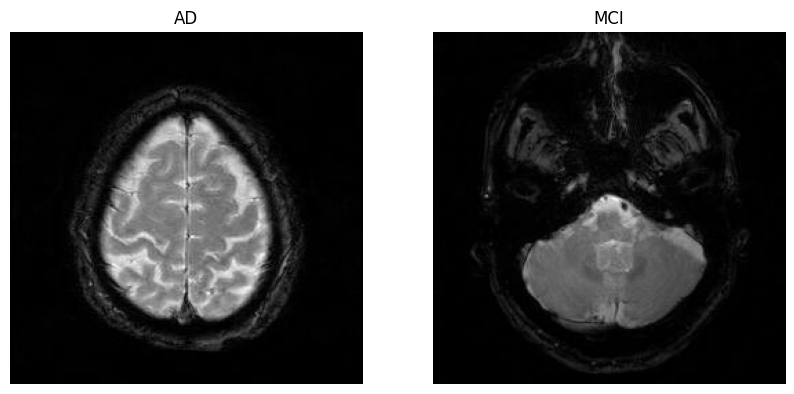

In [324]:
dataset = ImageDataset(AD_PATH, MCI_PATH)
dataset.show_sample()

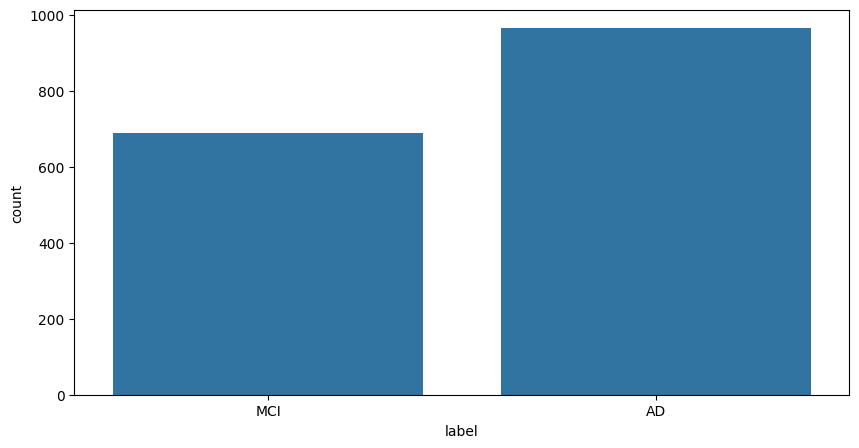

In [325]:
dataset.plot_distribution()

## Data Augmentation

Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the images. This helps to improve the generalization of the model and reduce overfitting. We will apply random rotations, flips, shifts, and zooms to the images. 

In [326]:
dataset.augment_dataset()

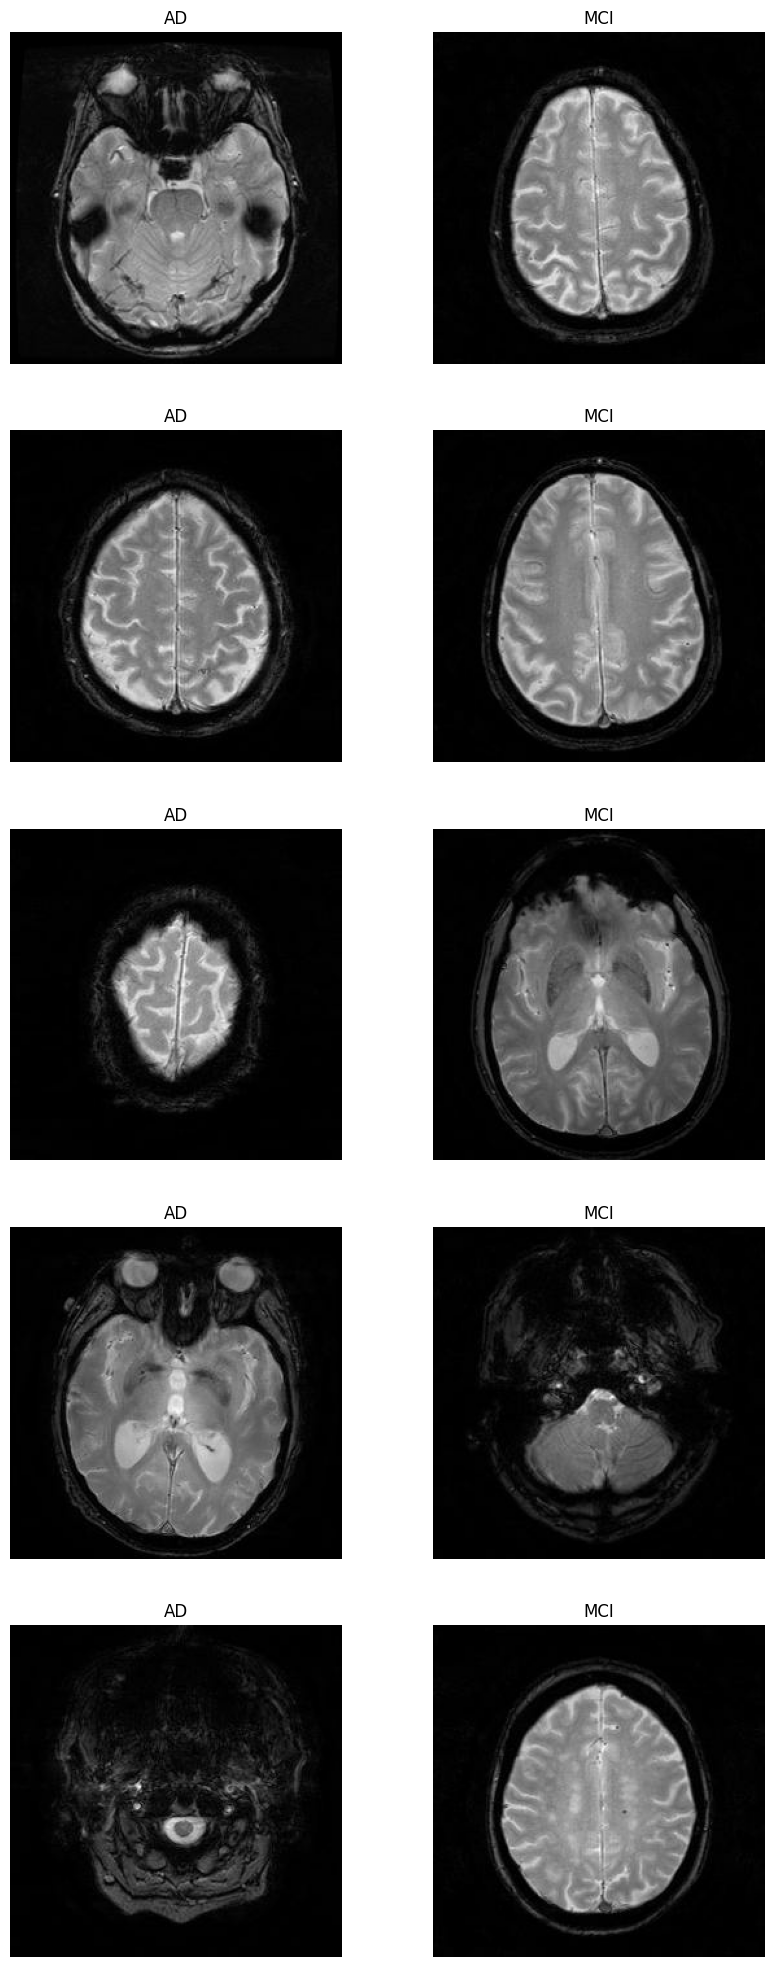

In [327]:
dataset.show_sample(5)

## Train and Test Split

We will split the dataset into training and testing sets. We will use 95% of the data for training and 5% for testing. From the training set, we will further split 10% of the data for validation.

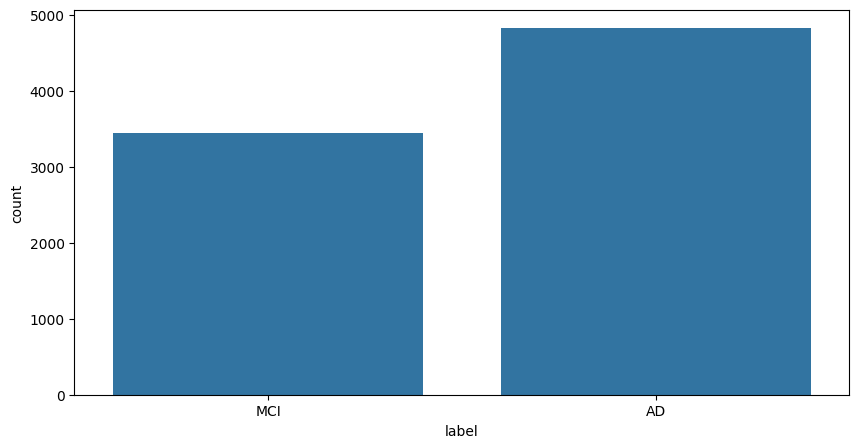

In [328]:
dataset.plot_distribution()

In [329]:
print(dataset.concat_data.element_spec)

(TensorSpec(shape=(256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [330]:
dataset.split_train_test_validation()

Train size     : 7072
Validation size: 785
Test size      : 413


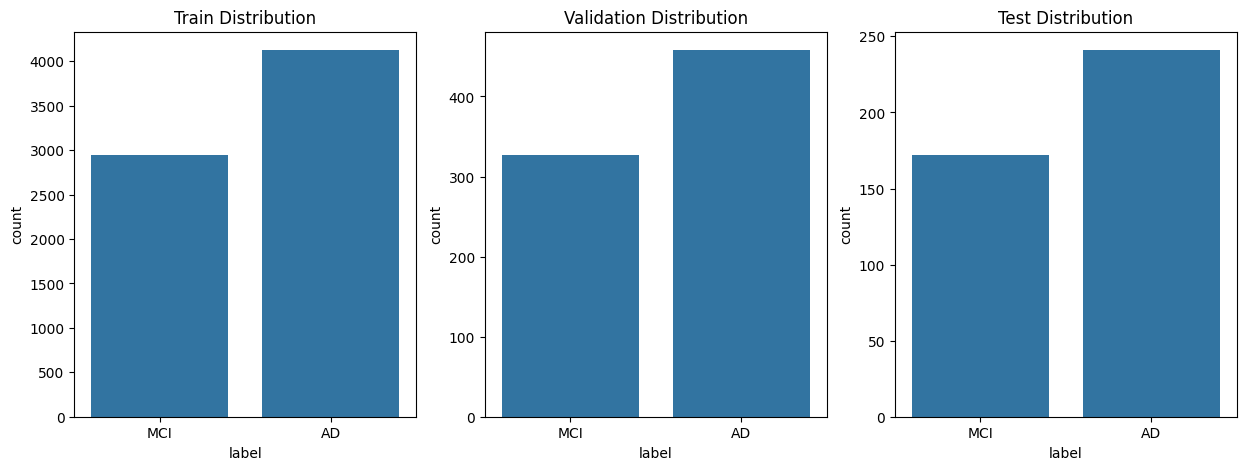

In [331]:
dataset.plot_distribution_split()

## Implementation

### Gloroit Initialization

The Glorot initialization, also known as Xavier initialization, is a method used to initialize the weights of a neural network. It is based on the idea that the weights should be initialized in such a way that the variance of the input and output of each layer is the same. This helps to prevent the gradients from becoming too large or too small during training. For a fully connected layer with input size `n_in` and output size `n_out`, the weights `W` are initialized according to a uniform distribution in the range:

$$
W \sim U\left[-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right]
$$

Here, `U[a, b]` denotes a uniform distribution in the range `[a, b]`. This initialization helps to avoid vanishing or exploding gradients at the start of the training process. 


### Activation Function

We will use the ReLU activation function in the hidden layers of the network. The ReLU function is a non-linear activation function that introduces non-linearity into the network and helps to learn complex patterns in the data. tanh and sigmoid activation functions are also used in the network. For output layer we will use softmax activation function.

Formulas for each of the activation functions are as follows:

$$ReLU(x) = max(0, x)$$

$$tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$

$$softmax(x) = \frac{e^{x_{i}}}{\sum_{j} e^{x_{j}}}$$

### Loss Function

We will use the categorical cross-entropy loss function to train the model. The categorical cross-entropy loss function is used for multi-class classification problems and measures the difference between the predicted probability distribution and the true probability distribution of the classes. The formula for the categorical cross-entropy loss function is as follows:

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i = 1}^{N} \sum_{j = 1}^{C} (y_{i} = j) log(\hat{y}_{i})$$

Where $y$ is the true probability distribution, $\hat{y}$ is the predicted probability distribution, and $N$ is the number of classes.

Using Cross-Entropy loss function after the softmax layer speeds the convergence of the neural network due to the gradient vanishing problem.


Another possible loss function is the negative log-likelihood loss function. The negative log-likelihood loss function is used for multi-class classification problems and measures the difference between the predicted probability distribution and the true probability distribution of the classes. The formula for the negative log-likelihood loss function is as follows: 

$$L(y, \hat{y}) = -\frac{1}{N} \sum_{i} log(\hat{y}_{i})$$

Where $y$ is the true probability distribution, $\hat{y}$ is the predicted probability distribution, and $N$ is the number of classes.

The reason we chose the categorical cross-entropy loss function is that it is more stable and faster to converge than the negative log-likelihood loss function.

### Optimizer

We will use the Adam optimizer to train the model. The Adam optimizer is an adaptive learning rate optimization algorithm that combines the advantages of two other popular optimization algorithms: AdaGrad and RMSProp. The Adam optimizer adapts the learning rate for each parameter based on the first and second moments of the gradients. This helps to speed up the convergence of the model and improve its performance.

### Regularization

We will use L2 regularization to prevent overfitting in the model. L2 regularization adds a penalty term to the loss function that penalizes large weights. This helps to prevent the model from fitting the noise in the training data and improves its generalization performance. The L2 regularization term is given by:

$$L2 = \lambda \sum_{i} w_{i}^{2}$$

Where $\lambda$ is the regularization strength and $w_{i}$ are the weights of the model.

### Dropout

We will use dropout regularization to prevent overfitting in the model. Dropout is a technique that randomly sets a fraction of the input units to zero during training. This helps to prevent the model from relying too much on any single input unit and improves its generalization performance. We will apply dropout to the hidden layers of the network.

### Batch Normalization

We will use batch normalization to improve the training of the model. Batch normalization is a technique that normalizes the input to each layer of the network to have zero mean and unit variance. This helps to stabilize the training process and speed up convergence. We will apply batch normalization to the hidden layers of the network.

### Model Architecture

The model architecture consists of a series of convolutional layers followed by max-pooling layers. The convolutional layers extract features from the input images, while the max-pooling layers downsample the feature maps to reduce the spatial dimensions. The output of the convolutional layers is flattened and passed through a series of fully connected layers to make the final prediction. The model uses ReLU activation functions in the hidden layers and softmax activation function in the output layer. The model is trained using the categorical cross-entropy loss function and the Adam optimizer.

The model architecture is as follows:

1.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
2.  Batch Normalization
3.  ReLU Activation
4.  Dropout (0.5)
5.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
6.  Batch Normalization
7.  ReLU Activation
8.  Max Pooling (pool size 2x2, stride 2x2)
9.  Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
10. Batch Normalization
11. ReLU Activation
12. Dropout (0.5)
13. Convolutional Layer (32 filters, kernel size 3x3, stride 1x1, padding same)
14. Batch Normalization
15. ReLU Activation
16. Max Pooling (pool size 2x2, stride 2x2)
17. Flatten
18. Fully Connected Layer (128 units)
19. Batch Normalization
20. ReLU Activation
21. Dropout (0.5)
22. Fully Connected Layer (64 units)
23. Batch Normalization
24. ReLU Activation
25. Dropout (0.5)
26. Fully Connected Layer (2 units)
27. Softmax Activation
28. Output Layer
29. Categorical Cross-Entropy Loss Function
30. Adam Optimizer